Installing required packages

In [ ]:
!python -m venv sign-env
!.\sign-env\Scripts\activate+
!python -m ipykernel install --user --name=sign-env
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# pip install --user mediapipe

Importing required packages

In [82]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from sklearn.model_selection import train_test_split
#from tensorflow.python.keras.utils import to_categorical #-----------mac
from tensorflow.python.keras.utils import to_categorical  #------------------windows
import tensorflow as tf
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

Holistic model and Drawing utilities :
Holistic for downloading the model and leveraging it to make detections, whereas the Drawing Utility helps draw the key-points on our face. 

In [83]:
holistic_mp = mp.solutions.holistic     
drawing_mp = mp.solutions.drawing_utils 

Mediapipe function will return our image and results back to the loop which will be used further. contain different types of landmarks for face, hands and pose

In [84]:
def detection_mediapipe(image, model):
    # convert color space from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    # image is no longer writeable
    image.flags.writeable = False
    # predictions
    results = model.process(image) 
    # image is writeable
    image.flags.writeable = True    
    # convert color space from RGB to BGR
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [85]:
def input_landmarks(image, results):  
    # pose connections
    drawing_mp.draw_landmarks(image, results.pose_landmarks, holistic_mp.POSE_CONNECTIONS,
                              drawing_mp.DrawingSpec(color=(255, 86, 170), thickness=2, circle_radius=4),
                              drawing_mp.DrawingSpec(color=(86, 255, 255), thickness=2, circle_radius=2))
    
    # left hand connections
    drawing_mp.draw_landmarks(image, results.left_hand_landmarks, holistic_mp.HAND_CONNECTIONS,
                              drawing_mp.DrawingSpec(color=(0, 127, 255), thickness=2, circle_radius=4),
                              drawing_mp.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=2))
    
    # right hand connections
    drawing_mp.draw_landmarks(image, results.right_hand_landmarks, holistic_mp.HAND_CONNECTIONS,
                              drawing_mp.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=4),
                              drawing_mp.DrawingSpec(color=(255, 255, 255), thickness=2, circle_radius=2))

Real-time loop to set our MediaPipe model. Using OpenCV to access our cameras, we will first setup video capture from the webcam feed and then loop through every single frame of it. Here, we will call the detection_mediapipe function defined previously to make detections on each frame and return the results

In [86]:
# feed from webcam device
cap = cv2.VideoCapture(0) 
# mediapipe model
with holistic_mp.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    # webcam access & loop through all frames
    while cap.isOpened():     
        # read feed/frames from webcam
        ret, frame = cap.read()
        # make detections
        image, results = detection_mediapipe(frame, holistic)     
        # draw formatted landmarks
        input_landmarks(image, results)       
        # show image to screen
        cv2.imshow('OpenCV Feed', image)
        # break gracefully if hit 'q' on keyboard
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    # release webcam
    cap.release()           
    # close down all frames
    cv2.destroyAllWindows() 
    cv2.waitKey(1)

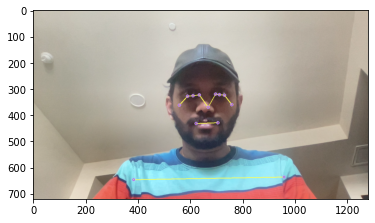

In [87]:
# apply landmarks and show
input_landmarks(frame, results)
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [88]:
#extracting the key-point values into a usable format
results.pose_landmarks

landmark {
  x: 0.5232366323471069
  y: 0.5151671767234802
  z: -0.5176372528076172
  visibility: 0.9997515678405762
}
landmark {
  x: 0.5451703071594238
  y: 0.44575631618499756
  z: -0.48527878522872925
  visibility: 0.9995812177658081
}
landmark {
  x: 0.5568906664848328
  y: 0.44817304611206055
  z: -0.48510751128196716
  visibility: 0.9995864033699036
}
landmark {
  x: 0.571131706237793
  y: 0.4510607421398163
  z: -0.4850565791130066
  visibility: 0.9995989203453064
}
landmark {
  x: 0.49625030159950256
  y: 0.44980186223983765
  z: -0.48483890295028687
  visibility: 0.9996936917304993
}
landmark {
  x: 0.47738713026046753
  y: 0.45344018936157227
  z: -0.4841236174106598
  visibility: 0.9997095465660095
}
landmark {
  x: 0.4617062211036682
  y: 0.45680689811706543
  z: -0.4844697415828705
  visibility: 0.9997495412826538
}
landmark {
  x: 0.5933824777603149
  y: 0.5013599991798401
  z: -0.23336705565452576
  visibility: 0.9996318221092224
}
landmark {
  x: 0.4374539852142334
  y

In [89]:
len(results.face_landmarks.landmark)

468

Pose :33X4=132  for x, y, z & visibility values

Left hand :21X3=63  for x, y & z values

Right hand :21X3=63  for x, y & z values

In [90]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)   
    #face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])#face, 

In [91]:
result_test = extract_keypoints(results)

In [92]:
np.save('0', result_test)

In [93]:
np.load('0.npy')

array([ 5.23236632e-01,  5.15167177e-01, -5.17637253e-01,  9.99751568e-01,
        5.45170307e-01,  4.45756316e-01, -4.85278785e-01,  9.99581218e-01,
        5.56890666e-01,  4.48173046e-01, -4.85107511e-01,  9.99586403e-01,
        5.71131706e-01,  4.51060742e-01, -4.85056579e-01,  9.99598920e-01,
        4.96250302e-01,  4.49801862e-01, -4.84838903e-01,  9.99693692e-01,
        4.77387130e-01,  4.53440189e-01, -4.84123617e-01,  9.99709547e-01,
        4.61706221e-01,  4.56806898e-01, -4.84469742e-01,  9.99749541e-01,
        5.93382478e-01,  5.01359999e-01, -2.33367056e-01,  9.99631822e-01,
        4.37453985e-01,  5.02987266e-01, -2.51432002e-01,  9.99773920e-01,
        5.52086294e-01,  5.95860302e-01, -4.20438826e-01,  9.99613106e-01,
        4.87215340e-01,  6.00133002e-01, -4.27617013e-01,  9.99717593e-01,
        7.49498665e-01,  8.83984268e-01, -7.51892552e-02,  9.93127525e-01,
        3.00333470e-01,  8.97810876e-01, -1.91659421e-01,  9.96689856e-01,
        8.90329003e-01,  

In [94]:
extract_keypoints(results).shape

(258,)

# Creating folder for dataset collection

sequence_number : 30 videos of data to be collected for each action
    
sequence_length : Each video is of 30 frames in length

In [95]:
# Path for exported data, numpy arrays
data_path = os.path.join('Dataset_folder')
# Actions that we aim to detect
actions = np.array(['hello','me','father','mother','yes','no','help','please', 'thank you','want','what','cat','again or repeat','more','fine','learn','done or finish','open','to','work','iloveyou'])
sequence_number = 30
sequence_length = 30

In [96]:
for action in actions:
    for sequence in range(sequence_number):
        try:
            os.makedirs(os.path.join(data_path, action, str(sequence)))
        except:
            pass

We collect all the key-point data by setting up video capture looping through each frame.

We have commented the block because we collected the training dataset for the project and will be reusing it for everty run, unless we want to collect new set of training data uncomment below code.

In [97]:
'''# Run this only once to extract train data
cap = cv2.VideoCapture(0) #to access webcam device

# set mediapipe model
with holistic_mp.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:
    for action in actions: # loop through actions
        for sequence in range(sequence_number): # loop through sequences/videos
            for frame_no in range(sequence_length): # loop through video length 
                # read frames
                ret, frame = cap.read()
                # make detections
                image, results = detection_mediapipe(frame, holistic)
                # draw landmarks
                input_landmarks(image, results)               
                # NEW collection wait logic
                if frame_no == 0:
                    cv2.putText(image, 'COLLECTING NOW...', (120, 200),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for Action: {} & Video: {}'.format(action, sequence), (15, 12),cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image) # show image on screen
                    cv2.waitKey(1500) # 1.5 seconds break
                else:
                    cv2.putText(image, 'Collecting frames for Action: {} & Video: {}'.format(action, sequence), (15, 12),cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 1, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image) # show image on screen
                
                # NEW extract key-points
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(data_path, action, str(sequence), str(frame_no))
                np.save(npy_path, keypoints)
                
                # break gracefully if hit 'q' on keyboard
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()           # release webcam
    cv2.destroyAllWindows() # close down all frames'''

"# Run this only once to extract train data\ncap = cv2.VideoCapture(0) #to access webcam device\n\n# set mediapipe model\nwith holistic_mp.Holistic(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as holistic:\n    for action in actions: # loop through actions\n        for sequence in range(sequence_number): # loop through sequences/videos\n            for frame_no in range(sequence_length): # loop through video length \n                # read frames\n                ret, frame = cap.read()\n                # make detections\n                image, results = detection_mediapipe(frame, holistic)\n                # draw landmarks\n                input_landmarks(image, results)               \n                # NEW collection wait logic\n                if frame_no == 0:\n                    cv2.putText(image, 'COLLECTING NOW...', (120, 200),cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3, cv2.LINE_AA)\n                    cv2.putText(image, 'Collecting frames for Action: {} & Vi

# Pre-process Data and Create Lables & Features

In [98]:
#actions list
label_map = {label:num for num, label in enumerate(actions)}
label_map

{'hello': 0,
 'me': 1,
 'father': 2,
 'mother': 3,
 'yes': 4,
 'no': 5,
 'help': 6,
 'please': 7,
 'thank you': 8,
 'want': 9,
 'what': 10,
 'cat': 11,
 'again or repeat': 12,
 'more': 13,
 'fine': 14,
 'learn': 15,
 'done or finish': 16,
 'open': 17,
 'to': 18,
 'work': 19,
 'iloveyou': 20}

In [99]:
sequences, labels = [], [] # blank arrays
for action in actions:
    for sequence in range(sequence_number):
        window = [] # blank array
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(data_path, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [100]:
X = np.array(sequences)
X.shape

(630, 30, 258)

In [101]:
np.array(labels).shape

(630,)

In [102]:
X = np.array(sequences)
y = to_categorical(labels).astype(int) # one-hot-encoding
y.shape

(630, 21)

train_test_split function we will perform training and testing partition with the test partition size being 5% of the data.

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05)

In [104]:
from tensorflow.python.keras.models import Sequential 
from tensorflow.python.keras.layers import LSTM, Dense 
from tensorflow.python.keras.callbacks import TensorBoard 

In [105]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

# Model Implementation

# 1) LSTM Model : with relu activation function

Sequential modeling : allows us to build a sequential neural network

LSTM layer : provides temporal component for the Neural Network & allows performing action detection

Dense layer : a normal fully connected layer

TensorBoard : allows to perform logging inside TensorBoard web app for tracing & monitoring model during training

In [ ]:
lstm_model = Sequential() 
# add 3 set of LSTM layers
lstm_model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=( 30, 258))) # 10 WILL BE 30
lstm_model.add(LSTM(128, return_sequences=True, activation='relu'))
lstm_model.add(LSTM(64, return_sequences=False, activation='relu')) 
# add 3 Dense layers
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dense(actions.shape[0], activation='softmax')) # actions layer

In [ ]:
lstm_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
lstm_h1=lstm_model.fit(X_train, y_train,validation_data = (X_test, y_test), epochs=500, callbacks=[tb_callback])

In [ ]:
lstm_model.summary()

In [ ]:
res = lstm_model.predict(X_test)

In [ ]:
actions[np.argmax(res[2])]

In [ ]:
print(res)
print(res[2])

In [ ]:
actions[np.argmax(y_test[2])]

In [ ]:
# Loss
loss=lstm_h1.history['loss']
val=lstm_h1.history['val_loss']
plt.plot(loss,label ='train loss')
plt.plot(val,label='validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show();

In [ ]:
# Accuracy
acc=lstm_h1.history['categorical_accuracy']
val=lstm_h1.history['val_categorical_accuracy']
plt.plot(acc,label ='train acc')
plt.plot(val,label='validation acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show();

In [ ]:
lstm_model.save('lstm_model.h5')

# 2) LSTM with tanH : with Tanh activation function

In [106]:
lstm_tanh_model = Sequential()
lstm_tanh_model.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(30, 258)))
lstm_tanh_model.add(LSTM(128, return_sequences=True, activation='tanh'))
lstm_tanh_model.add(LSTM(64, return_sequences=False, activation='tanh'))
lstm_tanh_model.add(Dense(64, activation='tanh'))
lstm_tanh_model.add(Dense(32, activation='tanh'))
lstm_tanh_model.add(Dense(actions.shape[0], activation='softmax'))

In [107]:
lstm_tanh_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
lstm_tanh_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 64)          82688     
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 128)         98816     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 21)                693       
Total params: 237,845
Trainable params: 237,845
Non-trainable params: 0
_________________________________________________________________


In [108]:
lstm_h2=lstm_tanh_model.fit(X_train, y_train,validation_data = (X_test, y_test), epochs=500, callbacks=[tb_callback])

Train on 598 samples, validate on 32 samples
Epoch 1/500
598/598 [==============================]598/598 [==============================] - 1s 2ms/step - loss: 2.6961 - categorical_accuracy: 0.1555 - val_loss: 2.1824 - val_categorical_accuracy: 0.4375

Epoch 2/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 2.1318 - categorical_accuracy: 0.2542 - val_loss: 1.7296 - val_categorical_accuracy: 0.4062

Epoch 3/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 1.8012 - categorical_accuracy: 0.3528 - val_loss: 1.5027 - val_categorical_accuracy: 0.4688

Epoch 4/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 1.6221 - categorical_accuracy: 0.4431 - val_loss: 1.3518 - val_categorical_accuracy: 0.4688

Epoch 5/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 1.4450 -

598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.3448 - categorical_accuracy: 0.8880 - val_loss: 0.4441 - val_categorical_accuracy: 0.8750

Epoch 41/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.3837 - categorical_accuracy: 0.8946 - val_loss: 0.2547 - val_categorical_accuracy: 0.9062

Epoch 42/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.2585 - categorical_accuracy: 0.9398 - val_loss: 0.2384 - val_categorical_accuracy: 0.9688

Epoch 43/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.3451 - categorical_accuracy: 0.8946 - val_loss: 0.2819 - val_categorical_accuracy: 0.9375

Epoch 44/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.2643 - categorical_accuracy: 0.9314 - val_loss: 0.3060 - va

598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.3403 - categorical_accuracy: 0.9114 - val_loss: 0.2426 - val_categorical_accuracy: 0.9375

Epoch 80/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.1955 - categorical_accuracy: 0.9465 - val_loss: 0.0559 - val_categorical_accuracy: 1.0000

Epoch 81/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.1173 - categorical_accuracy: 0.9716 - val_loss: 0.1171 - val_categorical_accuracy: 0.9688

Epoch 82/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.2614 - categorical_accuracy: 0.9281 - val_loss: 0.1487 - val_categorical_accuracy: 0.9375

Epoch 83/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.1796 - categorical_accuracy: 0.9515 - val_loss: 0.1494 - va

598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0084 - categorical_accuracy: 1.0000 - val_loss: 0.0088 - val_categorical_accuracy: 1.0000

Epoch 119/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0082 - categorical_accuracy: 1.0000 - val_loss: 0.0086 - val_categorical_accuracy: 1.0000

Epoch 120/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0081 - categorical_accuracy: 1.0000 - val_loss: 0.0085 - val_categorical_accuracy: 1.0000

Epoch 121/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0079 - categorical_accuracy: 1.0000 - val_loss: 0.0083 - val_categorical_accuracy: 1.0000

Epoch 122/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0078 - categorical_accuracy: 1.0000 - val_loss: 0.0081 

598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0044 - categorical_accuracy: 1.0000 - val_loss: 0.0045 - val_categorical_accuracy: 1.0000

Epoch 158/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0043 - categorical_accuracy: 1.0000 - val_loss: 0.0044 - val_categorical_accuracy: 1.0000

Epoch 159/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0043 - categorical_accuracy: 1.0000 - val_loss: 0.0043 - val_categorical_accuracy: 1.0000

Epoch 160/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0042 - categorical_accuracy: 1.0000 - val_loss: 0.0043 - val_categorical_accuracy: 1.0000

Epoch 161/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0041 - categorical_accuracy: 1.0000 - val_loss: 0.0042 

598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0026 - categorical_accuracy: 1.0000 - val_loss: 0.0026 - val_categorical_accuracy: 1.0000

Epoch 197/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0026 - categorical_accuracy: 1.0000 - val_loss: 0.0026 - val_categorical_accuracy: 1.0000

Epoch 198/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0025 - categorical_accuracy: 1.0000 - val_loss: 0.0025 - val_categorical_accuracy: 1.0000

Epoch 199/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0025 - categorical_accuracy: 1.0000 - val_loss: 0.0025 - val_categorical_accuracy: 1.0000

Epoch 200/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0025 - categorical_accuracy: 1.0000 - val_loss: 0.0025 

598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0016 - categorical_accuracy: 1.0000 - val_loss: 0.0016 - val_categorical_accuracy: 1.0000

Epoch 236/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0016 - categorical_accuracy: 1.0000 - val_loss: 0.0016 - val_categorical_accuracy: 1.0000

Epoch 237/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0016 - categorical_accuracy: 1.0000 - val_loss: 0.0016 - val_categorical_accuracy: 1.0000

Epoch 238/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0016 - categorical_accuracy: 1.0000 - val_loss: 0.0016 - val_categorical_accuracy: 1.0000

Epoch 239/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0015 - categorical_accuracy: 1.0000 - val_loss: 0.0015 

598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0010 - categorical_accuracy: 1.0000 - val_loss: 0.0010 - val_categorical_accuracy: 1.0000

Epoch 275/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0010 - categorical_accuracy: 1.0000 - val_loss: 0.0010 - val_categorical_accuracy: 1.0000

Epoch 276/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0010 - categorical_accuracy: 1.0000 - val_loss: 0.0010 - val_categorical_accuracy: 1.0000

Epoch 277/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0010 - categorical_accuracy: 1.0000 - val_loss: 0.0010 - val_categorical_accuracy: 1.0000

Epoch 278/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 0.0010 - categorical_accuracy: 1.0000 - val_loss: 9.9589e


Epoch 312/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 6.9959e-04 - categorical_accuracy: 1.0000 - val_loss: 6.9131e-04 - val_categorical_accuracy: 1.0000

Epoch 313/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 6.9237e-04 - categorical_accuracy: 1.0000 - val_loss: 6.8390e-04 - val_categorical_accuracy: 1.0000

Epoch 314/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 6.8520e-04 - categorical_accuracy: 1.0000 - val_loss: 6.7683e-04 - val_categorical_accuracy: 1.0000

Epoch 315/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 6.7812e-04 - categorical_accuracy: 1.0000 - val_loss: 6.7001e-04 - val_categorical_accuracy: 1.0000

Epoch 316/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 6.7115e-04

598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 4.7825e-04 - categorical_accuracy: 1.0000 - val_loss: 4.7046e-04 - val_categorical_accuracy: 1.0000

Epoch 350/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 4.7345e-04 - categorical_accuracy: 1.0000 - val_loss: 4.6578e-04 - val_categorical_accuracy: 1.0000

Epoch 351/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 4.6866e-04 - categorical_accuracy: 1.0000 - val_loss: 4.6075e-04 - val_categorical_accuracy: 1.0000

Epoch 352/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 4.6390e-04 - categorical_accuracy: 1.0000 - val_loss: 4.5598e-04 - val_categorical_accuracy: 1.0000

Epoch 353/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 4.5921e-04 - categorical_

598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 3.2880e-04 - categorical_accuracy: 1.0000 - val_loss: 3.2196e-04 - val_categorical_accuracy: 1.0000

Epoch 387/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 3.2550e-04 - categorical_accuracy: 1.0000 - val_loss: 3.1874e-04 - val_categorical_accuracy: 1.0000

Epoch 388/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 3.2221e-04 - categorical_accuracy: 1.0000 - val_loss: 3.1548e-04 - val_categorical_accuracy: 1.0000

Epoch 389/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 3.1900e-04 - categorical_accuracy: 1.0000 - val_loss: 3.1238e-04 - val_categorical_accuracy: 1.0000

Epoch 390/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 3.1578e-04 - categorical_

598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 2.2642e-04 - categorical_accuracy: 1.0000 - val_loss: 2.2092e-04 - val_categorical_accuracy: 1.0000

Epoch 424/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 2.2412e-04 - categorical_accuracy: 1.0000 - val_loss: 2.1862e-04 - val_categorical_accuracy: 1.0000

Epoch 425/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 2.2189e-04 - categorical_accuracy: 1.0000 - val_loss: 2.1631e-04 - val_categorical_accuracy: 1.0000

Epoch 426/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 2.1966e-04 - categorical_accuracy: 1.0000 - val_loss: 2.1411e-04 - val_categorical_accuracy: 1.0000

Epoch 427/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 2.1746e-04 - categorical_

598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 1.5602e-04 - categorical_accuracy: 1.0000 - val_loss: 1.5074e-04 - val_categorical_accuracy: 1.0000

Epoch 461/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 1.5446e-04 - categorical_accuracy: 1.0000 - val_loss: 1.4923e-04 - val_categorical_accuracy: 1.0000

Epoch 462/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 1.5293e-04 - categorical_accuracy: 1.0000 - val_loss: 1.4768e-04 - val_categorical_accuracy: 1.0000

Epoch 463/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 1.5139e-04 - categorical_accuracy: 1.0000 - val_loss: 1.4613e-04 - val_categorical_accuracy: 1.0000

Epoch 464/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 1.4988e-04 - categorical_

598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 1.0805e-04 - categorical_accuracy: 1.0000 - val_loss: 1.0360e-04 - val_categorical_accuracy: 1.0000

Epoch 498/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 1.0699e-04 - categorical_accuracy: 1.0000 - val_loss: 1.0258e-04 - val_categorical_accuracy: 1.0000

Epoch 499/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 1.0595e-04 - categorical_accuracy: 1.0000 - val_loss: 1.0159e-04 - val_categorical_accuracy: 1.0000

Epoch 500/500
598/598 [==============================]598/598 [==============================] - 1s 1ms/step - loss: 1.0491e-04 - categorical_accuracy: 1.0000 - val_loss: 1.0058e-04 - val_categorical_accuracy: 1.0000



In [109]:
lstm_tanh_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 64)          82688     
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 128)         98816     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 21)                693       
Total params: 237,845
Trainable params: 237,845
Non-trainable params: 0
_________________________________________________________________


In [110]:
res=lstm_tanh_model.predict(X_test)

In [111]:
actions[np.argmax(res[2])]

'work'

In [112]:
print(res)
print(res[2])

[[4.98605914e-06 9.47220144e-07 1.92614333e-08 1.97557270e-07
  1.93638380e-06 2.61784038e-07 9.61651040e-06 2.29208831e-06
  1.05805560e-08 1.76195881e-05 5.11486214e-05 6.17621509e-08
  2.29321859e-06 1.73677745e-05 1.55119290e-06 6.69097062e-08
  6.27030067e-06 9.99882221e-01 5.29160760e-09 8.17009720e-07
  2.18967926e-07]
 [1.27242785e-08 1.94892664e-07 2.06851311e-07 1.83629675e-06
  3.22809313e-09 1.22194151e-05 7.28351688e-06 9.79121978e-07
  5.23342521e-07 2.36709820e-06 1.61503294e-07 7.61191359e-08
  9.99908686e-01 2.51644069e-05 2.54016027e-06 1.75751775e-05
  2.18778860e-06 2.06611276e-06 1.51273034e-05 5.19603702e-07
  2.67564502e-07]
 [5.73473926e-07 3.75872666e-08 7.42118709e-06 2.86625390e-08
  4.08752521e-06 2.91830276e-07 1.01394100e-07 2.68670188e-08
  4.93556513e-07 7.27085308e-07 4.71361147e-07 5.41296913e-06
  2.02269416e-06 8.01425131e-08 4.99040951e-08 2.60883849e-06
  2.38761822e-06 5.17042110e-07 1.92422846e-07 9.99970436e-01
  2.01217767e-06]
 [1.72206319e-06

In [113]:
actions[np.argmax(y_test[2])]

'work'

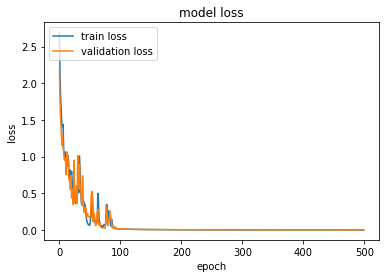

In [114]:
# Loss
loss=lstm_h2.history['loss']
val=lstm_h2.history['val_loss']
plt.plot(loss,label ='train loss')
plt.plot(val,label='validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show();

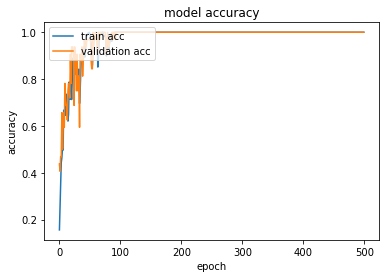

In [115]:
# Accuracy
acc=lstm_h2.history['categorical_accuracy']
val=lstm_h2.history['val_categorical_accuracy']
plt.plot(acc,label ='train acc')
plt.plot(val,label='validation acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show();

In [116]:
lstm_tanh_model.save('lstm_tanh_model.h5')

# 3) GRU Model

In [ ]:
GRU_model = tf.keras.Sequential([
    tf.keras.layers.GRU(64, return_sequences=True, activation='tanh', input_shape=(30, 258)),
    tf.keras.layers.GRU(128, return_sequences=True, activation='tanh'),
    tf.keras.layers.GRU(64, return_sequences=False, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(actions.shape[0], activation='softmax')
])

In [ ]:
GRU_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
GRU_h1=GRU_model.fit(X_train, y_train,validation_data = (X_test, y_test), epochs=500, callbacks=[tb_callback])

In [ ]:
GRU_model.summary()

In [ ]:
res=GRU_model.predict(X_test)

In [ ]:
actions[np.argmax(res[2])]

In [ ]:
print(res)
print(res[2])

In [ ]:
actions[np.argmax(y_test[2])]

In [ ]:
# Loss
loss=GRU_h1.history['loss']
val=GRU_h1.history['val_loss']
plt.plot(loss,label ='train loss')
plt.plot(val,label='validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show();

In [ ]:
# Accuracy
acc=GRU_h1.history['categorical_accuracy']
val=GRU_h1.history['val_categorical_accuracy']
plt.plot(acc,label ='train acc')
plt.plot(val,label='validation acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show();

In [ ]:
GRU_model.save('GRU_model.h5')

# 4) Vanilla RNN: simple RNN implementation to compare its performance with LSTM and GRU

In [ ]:
vanilla_rnn = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, return_sequences=True, activation='tanh', input_shape=(30, 258)),
    tf.keras.layers.SimpleRNN(128, return_sequences=True, activation='tanh'),
    tf.keras.layers.SimpleRNN(64, return_sequences=False, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(64, activation='tanh'),
    tf.keras.layers.Dense(actions.shape[0], activation='softmax')
])

In [ ]:
vanilla_rnn.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
#vanilla_rnn.summary()

In [ ]:
vanilla_h1 = vanilla_rnn.fit(X_train, y_train,validation_data = (X_test, y_test), epochs=500, callbacks=[tb_callback])

In [ ]:
vanilla_rnn.summary()

In [ ]:
res=vanilla_rnn.predict(X_test)

In [ ]:
actions[np.argmax(res[2])]

In [ ]:
# Loss
loss=vanilla_h1.history['loss']
val=vanilla_h1.history['val_loss']
plt.plot(loss,label ='train loss')
plt.plot(val,label='validation loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show();

In [ ]:
# Accuracy
acc=vanilla_h1.history['accuracy']
val=vanilla_h1.history['val_accuracy']
plt.plot(acc,label ='train acc')
plt.plot(val,label='validation acc')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show();

In [ ]:
vanilla_rnn.save('vanilla_rnn.h5')

# Loading the best performing model for prediction

In [117]:
model=lstm_tanh_model

In [118]:
model.load_weights('lstm_tanh_model.h5')

In [119]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, None, 64)          82688     
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 128)         98816     
_________________________________________________________________
lstm_9 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 21)                693       
Total params: 237,845
Trainable params: 237,845
Non-trainable params: 0
_________________________________________________________________


In [120]:
yhat = model.predict(X_test)

In [121]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
multilabel_confusion_matrix(ytrue, yhat)

array([[[31,  0],
        [ 0,  1]],

       [[31,  0],
        [ 0,  1]],

       [[30,  0],
        [ 0,  2]],

       [[30,  0],
        [ 0,  2]],

       [[31,  0],
        [ 0,  1]],

       [[30,  0],
        [ 0,  2]],

       [[31,  0],
        [ 0,  1]],

       [[30,  0],
        [ 0,  2]],

       [[30,  0],
        [ 0,  2]],

       [[28,  0],
        [ 0,  4]],

       [[31,  0],
        [ 0,  1]],

       [[31,  0],
        [ 0,  1]],

       [[31,  0],
        [ 0,  1]],

       [[28,  0],
        [ 0,  4]],

       [[29,  0],
        [ 0,  3]],

       [[29,  0],
        [ 0,  3]],

       [[31,  0],
        [ 0,  1]]])

In [122]:
accuracy_score(ytrue, yhat)

1.0

In [123]:
yhat_t = model.predict(X_train)
ytrue_t = np.argmax(y_train, axis=1).tolist()
yhat_t = np.argmax(yhat_t, axis=1).tolist()
multilabel_confusion_matrix(ytrue_t, yhat_t)

array([[[568,   0],
        [  0,  30]],

       [[569,   0],
        [  0,  29]],

       [[569,   0],
        [  0,  29]],

       [[570,   0],
        [  0,  28]],

       [[570,   0],
        [  0,  28]],

       [[569,   0],
        [  0,  29]],

       [[570,   0],
        [  0,  28]],

       [[569,   0],
        [  0,  29]],

       [[568,   0],
        [  0,  30]],

       [[570,   0],
        [  0,  28]],

       [[568,   0],
        [  0,  30]],

       [[570,   0],
        [  0,  28]],

       [[572,   0],
        [  0,  26]],

       [[569,   0],
        [  0,  29]],

       [[569,   0],
        [  0,  29]],

       [[569,   0],
        [  0,  29]],

       [[568,   0],
        [  0,  30]],

       [[572,   0],
        [  0,  26]],

       [[571,   0],
        [  0,  27]],

       [[571,   0],
        [  0,  27]],

       [[569,   0],
        [  0,  29]]])

In [124]:
accuracy_score(ytrue_t, yhat_t)

1.0

In [125]:
colors = [(245,117,16), (117,245,16), (16,117,245),(117, 16, 245),(245,16,117), (16,117,245),(117, 16, 245),
          (245,16,117), (16,117,245),(117, 16, 245), (16,117,245),(117, 16, 245),(245,16,117), (16,117,245)
          ,(245,16,117), (16,117,245),(117, 16, 245),(245,16,117), (16,117,245),(117, 16, 245),(245,16,117)]
def prob_viz(res, actions, input_frame, colors):
    print(res)
    output_frame = input_frame.copy()
    prob_cutoff=0
    action_num=0
    for num, prob in enumerate(res):
        if prob>prob_cutoff:
            prob_cutoff=prob
            action_num=num
        else:
            pass          
    
    res_probability = str(actions[action_num]) + ' ' + str((int(prob_cutoff*100))) + '%'
    cv2.rectangle(output_frame,(1,0), (350, 35), (18, 255, 17), -1)
    cv2.putText(output_frame,res_probability, (0,30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2, cv2.LINE_AA)
        
    return output_frame

# New real time detection

In [ ]:
sequence = []
sentence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
width =int(cap.get(cv2.CAP_PROP_FRAME_WIDTH) + 1)
height =int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT) + 1)
size = (width, height)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('lstm_model_output.avi', 0, cv2.VideoWriter_fourcc(*'MJPG'), 30, (width, height))
# Set mediapipe model 
with holistic_mp.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = detection_mediapipe(frame, holistic)
        
        # Draw landmarks
        input_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
                       
        # Viz probabilities
        image = prob_viz(res, actions, image, colors)

        cv2.putText(image, "Group 9 : Sign Language Detection project         ", (100,height-20),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (18, 17,255), 2, cv2.LINE_AA)
        
        out.write(image)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    out.release()
    cv2.destroyAllWindows()